In [1]:
# Imports
import numpy as np
import os

from pyplenet import generate
from pyplenet import export

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# PyPleNet Introduction

#### Project motivation and Data Description   
This project expands on the work done by Kamiel Gulpen for his master's thesis ```reference```. Gulpen devised a framework for creating artificial invidual-level interaction (person to person connection) networks for the city of Amsterdam by using anonymous group-level data from the Central Bureau of Statistics. This data categorized people in Amsterdam into groups based on *age*, *sex*, *ethnicity* and *education level*. One part of the data then defined the amount of people in each of these groups (group size data). Then for different "layers" the data defined the amount of edges (connections) between people in different groups (group interaction data). These layers included *neighbors*, *family*, *households*, *work / school*. An in-depth description of how this data was generated can be found in Gulpen's thesis.

This project modularizes, documents and packages this framework so it is easily useable with any similar type of data (e.g. other cities, communities or relevant multi-group networks). To achieve this, pyplenet was made to be completely agnostic to the number of categories used to define groups, the names of these categories and the number of groups defined. It is only required that the definitions are consistent between the group size data and the group interaction data. Pyplenet can be used to generate multiple network layers which can then be combined and treated as a multiplexed networks for whatever application is necessary.

#### Network Construction   
The network construction revolves around the two group random network (2GRN) creation algorithm defined by Gulpen. It allows for parameter-controlled individual-level network creation given group-level data. The core principle of 2GRN is to recreate the preferential attachment mechanism present in the Barabasi-Albert network algorithm. This mechanism is responsible for creating networks that share an important property of many real life social networks: scale-free degree distributions ```reference```. An in-depth description of this algorithm can be found in Gulpen's thesis. 

PyPleNet adapted 2GRN and preserved the parameters controlling the scale-free-ness and reciprocity of the generated networks. The reciprocity adds another element that reflects real life social networks. 

Importantly, the final degree dsitribution and reciprocity of the final networks are not entirely dictated by these parameters as there is already a certain level of pre-definition within the user's supplied group-level data. 

#### Framework Expansion   
Beyond modularizing Gulpen's network construction framework, this project:
- Implemented a custom network data-object: ```pyplenet.graph.FileBasedGraph```, along with all the necessary handling methods, to generate the large (+1 000 000 node, +20 000 000 edge) network graphs with speed (< 5 minutes). This object:
  - Uses a file-based system to avoid exceeded RAM crashes while preserving fast access.
  - Retains metadata so a user may filter nodes by their groups or category values (e.g. *age* or *ethnicity*).
  - Includes a subgraph extraction method.
  - Includes a networkx object conversion method.
- Implemented a network analysis module.
- Implemented an export export module which covers most standard network graph formats.
- Includes a tutorial and worked example of an investigation using pyplenet (included in this report).


#### Sections
The following sections are and desribe:
1. **Data** : The input data and its required properties
2. **Graph Construction** : The top-level graph constructor: ```pyplenet.generate```.
3. **Metadata** : How to handle, with an example, the group to node information dictionaries.
4. **Subgraph extraction** : The subgraph extraction methods.
5. **Analysis** : The ```pyplenet.analysis``` module + Networkx conversion and analysis.
6. **Export** : The ```pyplenet.export``` module.
7. **ABM** : A worked example of an investigation using pyplenet-generated networks with an Agent-Based Model.

#### 1. Data

PyPleNet requires two input files which can be either in ```.csv``` or ```.xlsx``` format:

**Group Size Data** (e.g: `fake_tab_n.csv`): Defines groups by their characteristics and their sizes
- any number of colums define characteristic categories, the values under those columns represent the subcategory. (e.g category: ```age```, subcategory: ```[20,30)```)
- a column labelled ```'n'``` defines the size (in graph: number of nodes) of each group.

In [2]:
# Population data example
pop_data = pd.read_csv('Data/fake_tab_n.csv')
print(pop_data.head())

       etngrp  oplniv geslacht      lft      n
0  Autochtoon       3      Man   [0,20)  14442
1  Autochtoon       3      Man  [20,30)  14424
2  Autochtoon       3      Man  [30,40)  13526
3  Autochtoon       3      Man  [40,50)  10026
4  Autochtoon       3      Man  [50,60)   9424


**Group Interaction Data** (`tab_werkschool.xlsx`): Defines the number of connections (directed edges) between groups.
- Each row contains information for two groups, a source group and a destination group. 
- A column labelled ```'n'``` defines the number of directed edges from the source group to destination group.
- The column category labels are divided via suffixes: ```'_src'``` for the source group and ```'_dst'``` for the destination group.

In [3]:
interaction_data = pd.read_excel('Data/tab_werkschool.xlsx')
print(interaction_data.head())

  geslacht_src lft_src  oplniv_src  etngrp_src geslacht_dst  lft_dst  \
0          Man  [0,20)           1  Autochtoon          Man   [0,20)   
1          Man  [0,20)           1  Autochtoon          Man   [0,20)   
2          Man  [0,20)           1  Autochtoon        Vrouw  [20,30)   
3          Man  [0,20)           1  Autochtoon        Vrouw   [0,20)   
4          Man  [0,20)           1  Autochtoon          Man   [0,20)   

   oplniv_dst  etngrp_dst       n        fn    N  
0           2  Autochtoon    2020  0.001841  159  
1           1  Autochtoon  262420  0.239212  159  
2           3  Autochtoon    3800  0.003464  159  
3           1  Autochtoon  248300  0.226340  159  
4           1  Marokkaans   57300  0.052232  159  


#### 1. Graph Construction

Generate a social network from population and interaction data.

In [4]:
# Generate network
pops = 'Data/fake_tab_n.csv'
links = 'Data/tab_werkschool.xlsx'

graph = generate(
    pops, 
    links, 
    preferential_attachment=0,        # Inverse Preferential attachment strength (see kamiel's thesis)
    scale=1,                          # Population scaling
    reciprocity=0.1,                  # Reciprocal edge probability
    base_path="graph_data"
)

Generating Nodes
857683 nodes initialized

Generating Links
-----------------
Total requested links: 29362450
Row 25165 of 25165
-----------------
Network Generated

Graph finalized: 857683 nodes, 30832978 edges


### 2. Metadata usage 

NOTE: include justifying why the group_to_node dict isnt already reversed.

In [5]:
# Targets: oplniv: 3, etngrp: "Overig", geslacht: "Vrouw" (any age)

# Find all groups that match our criteria
matching_groups = []
for group_id, attrs in graph.group_to_attrs.items():
    if ( attrs.get('etngrp') == "Overig" and
         attrs.get('oplniv') == 3 and  
         attrs.get('geslacht') == "Vrouw"
        ):
        matching_groups.append(group_id)

print(len(matching_groups), "groups matching criteria")

# Collect all nodes from matching groups
all_target_nodes = []
for group_id in matching_groups:
    all_target_nodes.extend(graph.group_to_nodes[group_id])

print(len(all_target_nodes), "nodes matching criteria")

# Select a random node from all matching groups
np.random.seed(40)
selected_node = np.random.choice(all_target_nodes)

print(f"node ID:{selected_node} selected")

8 groups matching criteria
52626 nodes matching criteria
node ID:642110 selected


#### 3. Subgraph Extraction
show how to use metadata dictionaries to target a node in a group
Extract a manageable subgraph for analysis and visualization.
Descirbe that is=t is BFS

In [6]:
# Extract subgraph around our selected node
temp_dir = 'subgraph_data' # note that when creating a subgraph an empty/non-existent directory is needed.

subgraph = graph.extract_subgraph(
    center_node=selected_node,
    max_nodes=1500,
    output_path=temp_dir
)

print(f"Subgraph: {subgraph.number_of_nodes()} nodes, {subgraph.number_of_edges()} edges")

Extracting subgraph: center=642110, max_nodes=1500
Graph finalized: 1500 nodes, 2273 edges
Subgraph created: 1500 nodes, 2273 edges
Saved to: subgraph_data
Subgraph: 1500 nodes, 2273 edges


## 3. Comparative Network Analysis

The subgraph can then be analyzed in two different ways. 
- Use the built-in ```pyplenet.analysis``` module.
- Use the ```FileBasedGraph.to_networkx()``` function to convert the ```FileBasedGraph``` object to a networkx object. Then use the large networkx selection of analysis methods.

=== Network Statistics ===
Number of nodes: 1500
Number of edges: 2273
Is directed: True

Reciprocity: 0.2992
Average clustering coefficient: 0.0585
Calculating shortest path distribution...


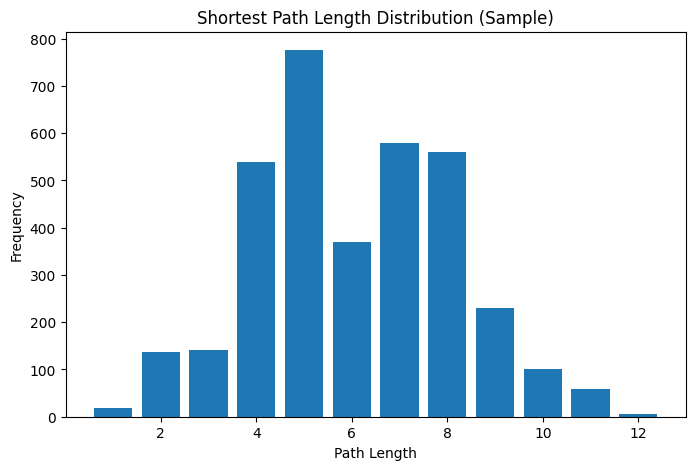

Average path length: 6.06
Path length std: 2.06
Calculating degree distribution...
Average out-degree (excluding isolates): 3.74


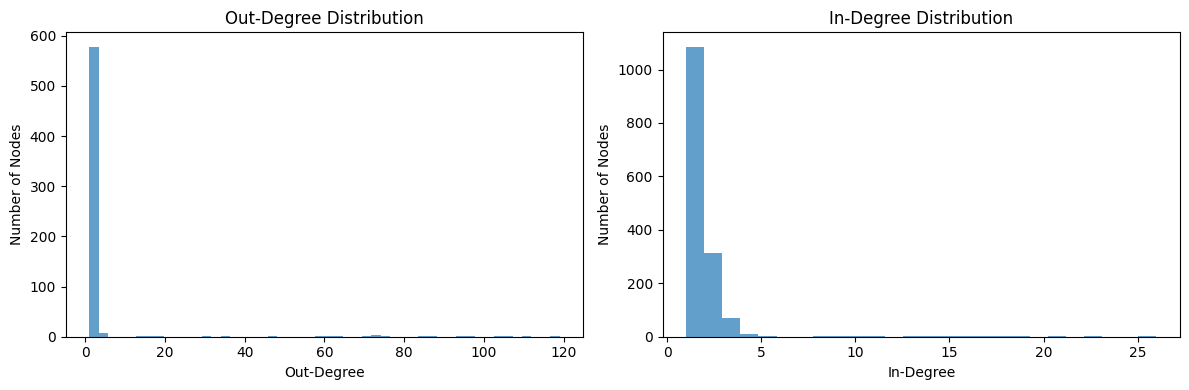

Average in-degree (excluding isolates): 1.52
=== Statistics Complete ===


In [7]:
# Using pyplenet.analysis
import pyplenet.analysis as pa
pa.runstats(subgraph)

In [17]:
# Using NetworkX for analysis:
nx_graph = subgraph.to_networkx()

print( )
# Basic properties and key metrics
print(f"Nodes: {nx_graph.number_of_nodes()}, Edges: {nx_graph.number_of_edges()}")
print(f"Reciprocity: {nx.reciprocity(nx_graph):.3f}")
print(f"Clustering: {nx.average_clustering(nx_graph.to_undirected()):.3f}")

# Degree statistics (excluding isolates)
in_degrees = [d for n, d in nx_graph.in_degree() if d > 0]
out_degrees = [d for n, d in nx_graph.out_degree() if d > 0]
print(f"Avg in-degree: {np.mean(in_degrees):.2f}, Avg out-degree: {np.mean(out_degrees):.2f}")

# Sample path lengths
import random
random.seed(42)
sampled_nodes = random.sample(list(nx_graph.nodes()), min(100, nx_graph.number_of_nodes()))
path_lengths = []
for source in sampled_nodes:
    paths = nx.single_source_shortest_path_length(nx_graph, source)
    path_lengths.extend([length for target, length in paths.items() if target != source][:50])

if path_lengths:
    print(f"Avg path length: {np.mean(path_lengths):.2f}")

# Store degrees for visualization
degrees = [d for n, d in nx_graph.degree()]

NetworkX conversion complete: 1500 nodes, 2273 edges

Nodes: 1500, Edges: 2273
Reciprocity: 0.299
Clustering: 0.025
Avg in-degree: 1.52, Avg out-degree: 3.74
Avg path length: 2.40


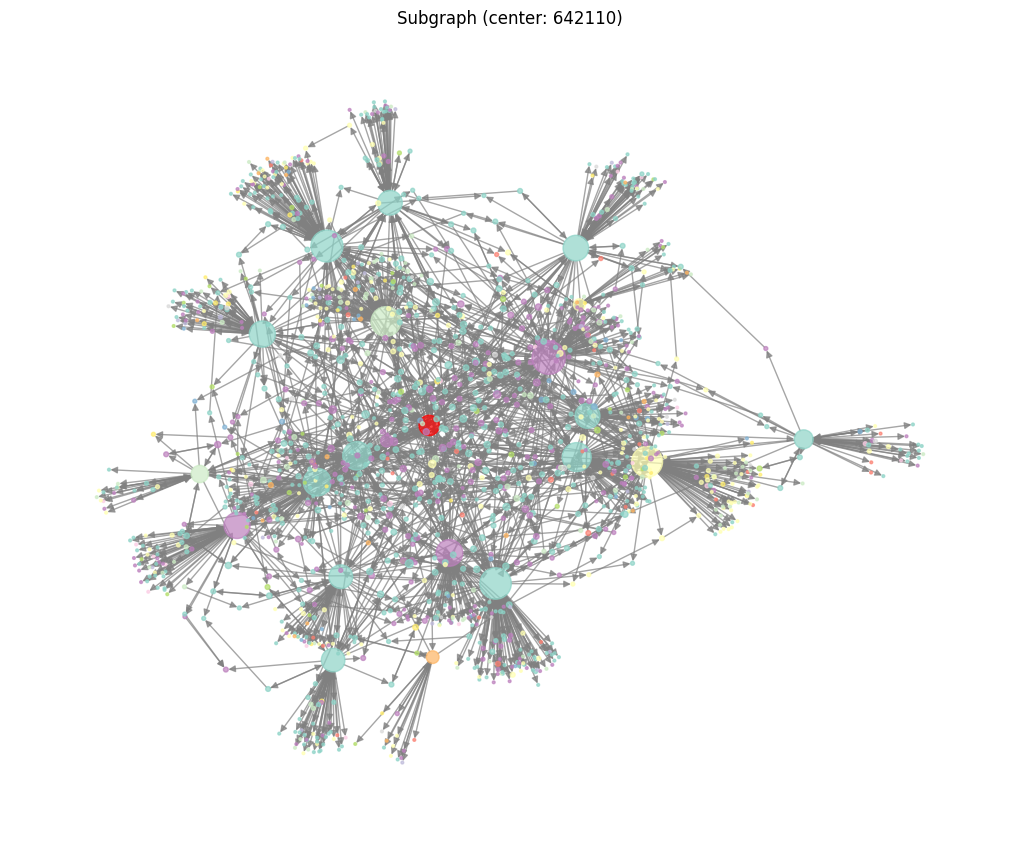

In [9]:
# Visualize network
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(nx_graph)

node_sizes = [2*d * 2 for d in degrees]

# Color nodes by group using subgraph.group_to_nodes if available
node_colors = ['lightblue'] * nx_graph.number_of_nodes()

# the graph object contains a group_to_node dict, we reverse it here
node_to_group = {} 
for group, nodes in subgraph.group_to_nodes.items():
    for node in nodes:
        node_to_group[node] = group

# reducing to a set and coloring by group
groups = sorted(set(node_to_group.values()))
colors = plt.cm.Set3(np.linspace(0, 1, len(groups)))
group_to_color = {g: colors[i] for i, g in enumerate(groups)}
node_colors = [
    group_to_color.get(node_to_group.get(n, None), 'lightblue')
    for n in nx_graph.nodes()
]

# Highlight center node
if selected_node in nx_graph.nodes():
    center_idx = list(nx_graph.nodes()).index(selected_node)
    node_colors[center_idx] = 'red'

nx.draw(nx_graph, pos, node_color=node_colors, node_size=node_sizes, 
        with_labels=False, edge_color='gray', alpha=0.7, arrows=True)
plt.title(f'Subgraph (center: {selected_node})')
plt.show()

## 4. Exporting

The ```pyplenet.export``` module contains many export functions for various standard graoh formats.

The module also includes export function for the graph metadata stored in the ```FileBasedGraph.group_to_attrs_csv``` and ```FileBasedGraph.group_to_nodes``` dicts. These can be used to map any node to its group (by reversing the ```group_to_attrs``` dict) and any group to its attributes.

In [18]:
# Export to multiple formats
os.makedirs("Exports", exist_ok=True)

# Export using pyplenet.export module -
export.edge_txt(subgraph, "Exports/subgraph.txt")
export.mtx(subgraph, "Exports/subgraph.mtx")

export.group_to_attrs_csv(subgraph.group_to_attrs, "Exports/group_attributes.csv")
print("Exported group attributes")

export.group_to_nodes_csv(subgraph.group_to_nodes, "Exports/group_nodes.csv")
print("Exported group-to-nodes mapping")

Edge list exported to Exports/subgraph.txt
Matrix Market format exported to Exports/subgraph.mtx
Exported group attributes
Exported group-to-nodes mapping
